In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4

In [2]:
# CF-Compliant ROMS ocean model output
# browse: http://geoport.whoi.edu/thredds/dodsC/examples/bora_feb.nc.html

# DAP URL
#url='http://geoport.whoi.edu/thredds/dodsC/examples/bora_feb.nc'

nc = netCDF4.Dataset('ocean_avg_1161.nc')
mask = nc.variables['mask_rho'][:]

# read longitude, latitude
lon_rho = nc.variables['lon_rho'][:,:]
lat_rho = nc.variables['lat_rho'][:,:]

# read water depth
depth = nc.variables['h'][:,:]

'''
z(n,k,j,i) = eta(n,j,i)*(1+s(k)) + depth_c*s(k) +
             (depth(j,i)-depth_c)*C(k)

  C(k) = (1-b)*sinh(a*s(k))/sinh(a) + 
         b*[tanh(a*(s(k)+0.5))/(2*tanh(0.5*a)) - 0.5]

formula_terms: s: s_rho eta: zeta depth: h a: theta_s b: theta_b depth_c: hc
'''

'\nz(n,k,j,i) = eta(n,j,i)*(1+s(k)) + depth_c*s(k) +\n             (depth(j,i)-depth_c)*C(k)\n\n  C(k) = (1-b)*sinh(a*s(k))/sinh(a) + \n         b*[tanh(a*(s(k)+0.5))/(2*tanh(0.5*a)) - 0.5]\n\nformula_terms: s: s_rho eta: zeta depth: h a: theta_s b: theta_b depth_c: hc\n'

In [3]:
s = nc.variables['s_rho'][:]
a = nc.variables['theta_s'][:]
b = nc.variables['theta_b'][:]
depth_c = nc.variables['hc'][:]

C = (1-b)*np.sinh(a*s)/np.sinh(a) + b*[np.tanh(a*(s+0.5))/(2*np.tanh(0.5*a)) - 0.5]

In [4]:
nc.variables.keys()

dict_keys(['ntimes', 'ndtfast', 'dt', 'dtfast', 'dstart', 'nHIS', 'ndefHIS', 'nRST', 'ntsAVG', 'nAVG', 'ndefAVG', 'Falpha', 'Fbeta', 'Fgamma', 'nl_tnu2', 'nl_visc2', 'LuvSponge', 'LtracerSponge', 'Akt_bak', 'Akv_bak', 'rdrg', 'rdrg2', 'Zob', 'Zos', 'Znudg', 'M2nudg', 'M3nudg', 'Tnudg', 'rho0', 'gamma2', 'LuvSrc', 'LwSrc', 'LtracerSrc', 'LsshCLM', 'Lm2CLM', 'Lm3CLM', 'LtracerCLM', 'LnudgeM2CLM', 'LnudgeM3CLM', 'LnudgeTCLM', 'spherical', 'xl', 'el', 'Vtransform', 'Vstretching', 'theta_s', 'theta_b', 'Tcline', 'hc', 's_rho', 's_w', 'Cs_r', 'Cs_w', 'h', 'f', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'lon_psi', 'lat_psi', 'angle', 'mask_rho', 'mask_u', 'mask_v', 'mask_psi', 'ocean_time', 'zeta', 'ubar', 'vbar', 'u', 'v', 'temp', 'salt'])

In [5]:
print (nc.variables['s_rho'])

<class 'netCDF4._netCDF4.Variable'>
float64 s_rho(s_rho)
    long_name: S-coordinate at RHO-points
    valid_min: -1.0
    valid_max: 0.0
    positive: up
    standard_name: ocean_s_coordinate_g1
    formula_terms: s: s_rho C: Cs_r eta: zeta depth: h depth_c: hc
    field: s_rho, scalar
unlimited dimensions: 
current shape = (40,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [6]:
# Reshape 1D vertical variables so we can broadcast
C.shape = (np.size(C), 1, 1)
s.shape = (np.size(s), 1, 1)

In [7]:
tidx = -1       # just get the final time step, for now.
# read a 3D temperature field at specified time step
temp = nc.variables['temp'][tidx, :, :, :]
# read a 2D water level (height of ocean surface) at specified time step
eta = nc.variables['zeta'][tidx, :, :]
# calculate the 3D field of z values (vertical coordinate) at this time step
z = eta*(1+s) + depth_c*s + (depth-depth_c)*C

In [8]:
(eta*s).shape

(40, 414, 424)

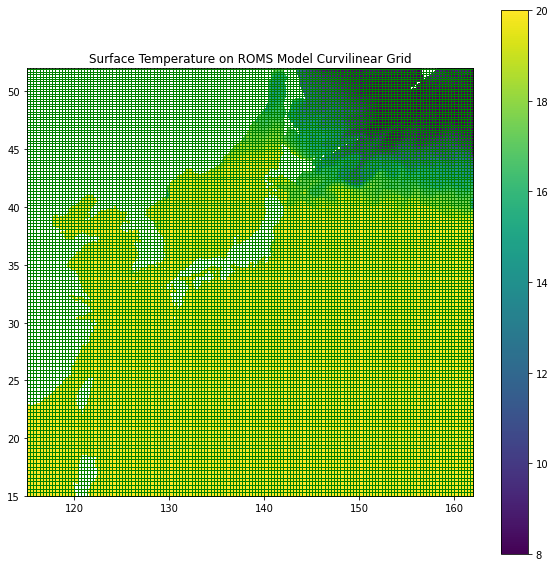

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,aspect=1.0/np.cos(np.mean(lat_rho.flatten()) * np.pi / 180.0))
pc3 = plt.pcolormesh(lon_rho,lat_rho,temp[-1,:,:], vmin=8, vmax=20)# plot surface temperature
plt.plot(lon_rho[::3,::3],lat_rho[::3,::3],'g+');
plt.plot(lon_rho.T[::3,::3],lat_rho.T[::3,::3],'g+');
plt.title('Surface Temperature on ROMS Model Curvilinear Grid')
plt.colorbar();

In [10]:
lon_rho.shape

(414, 424)

In [11]:
lon3d = np.ones((20,1,1))*lon_rho
lon3d.shape

(20, 414, 424)

In [12]:
lon3d[:,1,1]

masked_array(data=[115.11111111, 115.11111111, 115.11111111, 115.11111111,
                   115.11111111, 115.11111111, 115.11111111, 115.11111111,
                   115.11111111, 115.11111111, 115.11111111, 115.11111111,
                   115.11111111, 115.11111111, 115.11111111, 115.11111111,
                   115.11111111, 115.11111111, 115.11111111, 115.11111111],
             mask=False,
       fill_value=1e+20)

In [13]:
import numpy as np
lon3d=np.ma.getdata(lon3d)
z=np.ma.getdata(z)
temp=np.ma.masked_where(np.isnan(temp),temp)

In [14]:
temp=np.ma.getdata(temp)

In [15]:
lon3d[:,3,2]

array([115.22222222, 115.22222222, 115.22222222, 115.22222222,
       115.22222222, 115.22222222, 115.22222222, 115.22222222,
       115.22222222, 115.22222222, 115.22222222, 115.22222222,
       115.22222222, 115.22222222, 115.22222222, 115.22222222,
       115.22222222, 115.22222222, 115.22222222, 115.22222222])

In [16]:
temp

array([[[1.6254146e+00, 1.6221154e+00, 1.6260952e+00, ...,
         1.0552183e+00, 1.0564412e+00, 1.0566005e+00],
        [1.6287140e+00, 1.6790884e+00, 1.6812670e+00, ...,
         1.0894371e+00, 1.0872766e+00, 1.0567598e+00],
        [1.6367377e+00, 1.7118038e+00, 1.7347623e+00, ...,
         1.0913347e+00, 1.0934052e+00, 1.0599027e+00],
        ...,
        [9.9999999e+36, 9.9999999e+36, 9.9999999e+36, ...,
         1.1213564e+00, 1.1130903e+00, 1.0894898e+00],
        [9.9999999e+36, 9.9999999e+36, 9.9999999e+36, ...,
         1.1132871e+00, 1.1072711e+00, 1.0893073e+00],
        [9.9999999e+36, 9.9999999e+36, 9.9999999e+36, ...,
         1.0888187e+00, 1.0889717e+00, 1.0891395e+00]],

       [[1.8303611e+00, 1.8283825e+00, 1.8272169e+00, ...,
         1.0851254e+00, 1.0853094e+00, 1.0846603e+00],
        [1.8323396e+00, 1.8888687e+00, 1.8775376e+00, ...,
         1.1553990e+00, 1.1619760e+00, 1.0840112e+00],
        [1.8337435e+00, 1.8777925e+00, 1.8561748e+00, ...,
         1.152

TypeError: Incompatible X, Y inputs to pcolormesh; see help(pcolormesh)

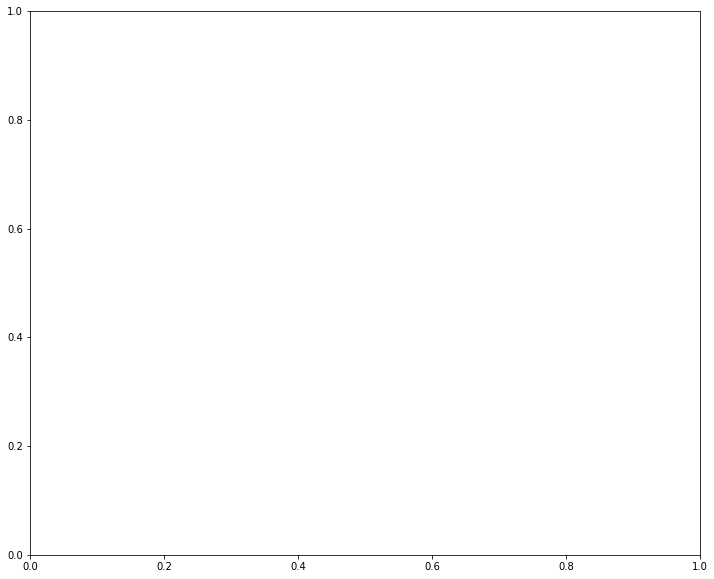

In [17]:
jval=10
irange=range(200,230)
fig = plt.figure(figsize=(12,10))

plt.pcolormesh(lon3d[:,jval,irange],z[:,jval,irange],temp[:,jval,irange],shading='faceted')
plt.title('Temperature Section along Adriatic, ocean_s_coordinate vertical coordinate');

In [18]:
!pip install cartopy
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

import xarray as xr

In [19]:
ds = xr.open_dataset('ocean_avg_1161.nc', chunks={'ocean_time': 1})

In [20]:
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

In [21]:
variables = ['salt', 'zeta']
ds[variables].isel(ocean_time=slice(47, None, 7*24),
                   xi_rho=slice(300, None)).to_netcdf('ROMS_example.nc', mode='w')

In [83]:
ds.info
list(ds.keys())

['ntimes',
 'ndtfast',
 'dt',
 'dtfast',
 'dstart',
 'nHIS',
 'ndefHIS',
 'nRST',
 'ntsAVG',
 'nAVG',
 'ndefAVG',
 'Falpha',
 'Fbeta',
 'Fgamma',
 'nl_tnu2',
 'nl_visc2',
 'LuvSponge',
 'LtracerSponge',
 'Akt_bak',
 'Akv_bak',
 'rdrg',
 'rdrg2',
 'Zob',
 'Zos',
 'Znudg',
 'M2nudg',
 'M3nudg',
 'Tnudg',
 'rho0',
 'gamma2',
 'LuvSrc',
 'LwSrc',
 'LtracerSrc',
 'LsshCLM',
 'Lm2CLM',
 'Lm3CLM',
 'LtracerCLM',
 'LnudgeM2CLM',
 'LnudgeM3CLM',
 'LnudgeTCLM',
 'spherical',
 'xl',
 'el',
 'Vstretching',
 'theta_s',
 'theta_b',
 'Tcline',
 'f',
 'pm',
 'pn',
 'angle',
 'mask_rho',
 'mask_u',
 'mask_v',
 'mask_psi',
 'zeta',
 'ubar',
 'vbar',
 'u',
 'v',
 'temp',
 'salt']

In [23]:
if ds.Vtransform == 1:
    Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
    z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
elif ds.Vtransform == 2:
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho

ds.coords['z_rho'] = z_rho.transpose()   # needing transpose seems to be an xarray bug

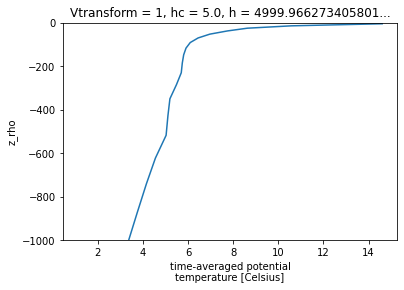

In [24]:
temp_sect=ds.temp.isel(xi_rho=350, eta_rho=300,ocean_time=0)
temp_sect.plot(y='z_rho') 
plt.ylim([-1000,0]);
#temp_sect.dims
depth_temp=temp_sect.coords["z_rho"].values
depth_temp_value=temp_sect.values

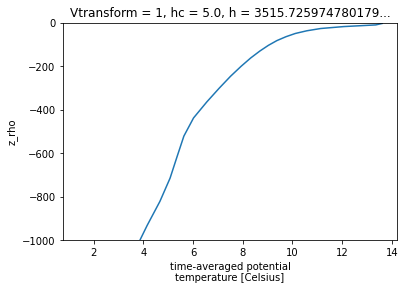

In [25]:
temp_sect=ds.temp.isel(xi_rho=300, eta_rho=300,ocean_time=0)
temp_sect.plot(y='z_rho') 
plt.ylim([-1000,0]);
#temp_sect.dims
depth_temp=temp_sect.coords["z_rho"].values
depth_temp_value=temp_sect.values

In [26]:
temp_sect

<xarray.DataArray 'temp' (s_rho: 40)>
dask.array<getitem, shape=(40,), dtype=float32, chunksize=(40,), chunktype=numpy.ndarray>
Coordinates:
    Vtransform  int32 1
    hc          float64 5.0
  * s_rho       (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    Cs_r        (s_rho) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    h           float64 dask.array<chunksize=(), meta=np.ndarray>
    lon_rho     float64 dask.array<chunksize=(), meta=np.ndarray>
    lat_rho     float64 dask.array<chunksize=(), meta=np.ndarray>
    ocean_time  datetime64[ns] 2019-07-14T12:00:00
    z_rho       (s_rho) float64 dask.array<chunksize=(40,), meta=np.ndarray>
Attributes:
    long_name:  time-averaged potential temperature
    units:      Celsius
    time:       ocean_time
    field:      temperature, scalar, series

In [27]:
lon=temp_sect.coords["lon_rho"].values
lat=temp_sect.coords["lat_rho"].values
lon,lat

(array(148.33333333), array(43.58621254))

In [28]:
depth_temp
import pandas as pd

# Create the dataframe
depth_df = pd.DataFrame(depth_temp)
depth_temp_df=pd.DataFrame(depth_temp_value)

In [29]:
depth_df.columns=["Depth"]
depth_temp_df.columns=["Temp"]

In [30]:
depth_list=[10,20,30,50,75,100,125,150,200,250,300,400,500]

In [31]:
import numpy as np
index = []
for depth in depth_list:
    temp=np.absolute(-depth_temp-depth).argmin()
    index.append(temp)

index

[38, 37, 36, 34, 32, 31, 30, 29, 28, 27, 26, 25, 23]

In [32]:
depth_temp

array([-3.38677300e+03, -3.15107878e+03, -2.94186232e+03, -2.75568576e+03,
       -2.58943147e+03, -2.44024611e+03, -2.30548933e+03, -2.18268760e+03,
       -2.06949476e+03, -1.96366233e+03, -1.86302418e+03, -1.76550161e+03,
       -1.66913656e+03, -1.57215942e+03, -1.47309430e+03, -1.37089571e+03,
       -1.26509660e+03, -1.15593186e+03, -1.04439081e+03, -9.32156707e+02,
       -8.21416666e+02, -7.14567115e+02, -6.13879409e+02, -5.21206601e+02,
       -4.37796051e+02, -3.64232920e+02, -3.00498161e+02, -2.46099045e+02,
       -2.00225837e+02, -1.61898883e+02, -1.30086254e+02, -1.03786071e+02,
       -8.20764843e+01, -6.41403242e+01, -4.92720934e+01, -3.68739412e+01,
       -2.64456029e+01, -1.75717100e+01, -9.90858897e+00, -3.17174381e+00])

In [33]:
result=pd.concat([depth_df,depth_temp_df],axis=1)
result
#result=result.sort_values(by='Depth',ascending=False)

,Depth,Temp
0,-3386.772998,1.367213
1,-3151.078777,1.499701
2,-2941.862322,1.607534
3,-2755.685764,1.702241
4,-2589.431465,1.796924
5,-2440.246105,1.901636
6,-2305.489335,2.007083
7,-2182.687604,2.097728
8,-2069.494757,2.162114
9,-1963.662335,2.215241


In [34]:
index

[38, 37, 36, 34, 32, 31, 30, 29, 28, 27, 26, 25, 23]

In [35]:
temp2=pd.DataFrame()

In [36]:
temp2

""


In [37]:
for idx in index:
         #print(idx)
         temp2=temp2.append(result.iloc[idx,:])

In [38]:
temp2

,Depth,Temp
38,-9.908589,13.349315
37,-17.571710,12.059571
36,-26.445603,11.135011
34,-49.272093,10.113944
32,-82.076484,9.372159
31,-103.786071,9.032688
30,-130.086254,8.687668
29,-161.898883,8.320186
28,-200.225837,7.934277
27,-246.099045,7.509389


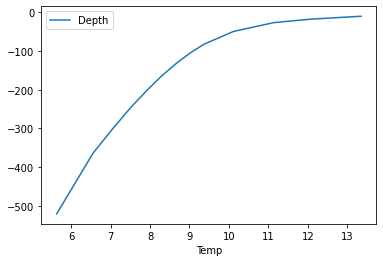

In [39]:
temp2.plot(x='Temp',y='Depth',style='-')

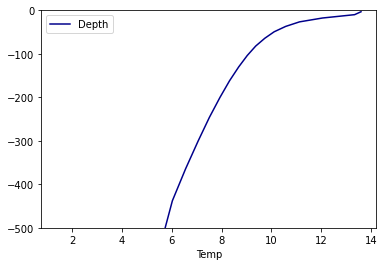

In [40]:
result.plot(x='Temp', y='Depth',style='-',c='DarkBlue')
plt.ylim([-500,0]);

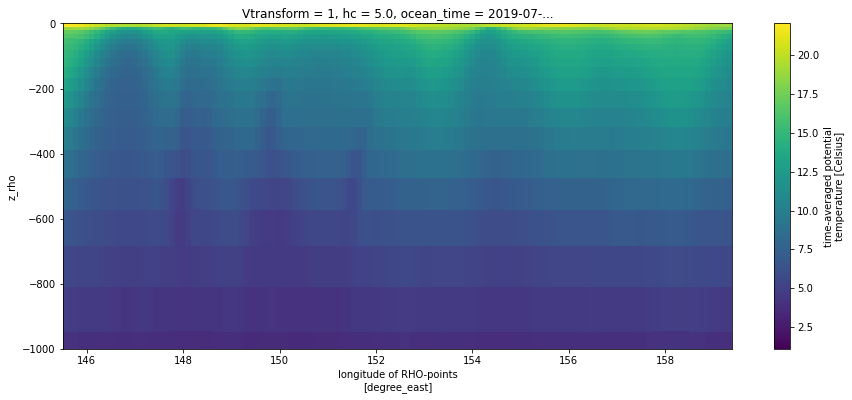

In [153]:
section = ds.temp.isel(xi_rho=slice(275,400), eta_rho=250, ocean_time=0)
section.plot(x='lon_rho', y='z_rho', figsize=(15, 6), clim=(25, 35),linestyle='dashed')
plt.ylim([-1000, 1]);

In [154]:
section

<xarray.DataArray 'temp' (s_rho: 40, xi_rho: 125)>
dask.array<getitem, shape=(40, 125), dtype=float32, chunksize=(40, 125), chunktype=numpy.ndarray>
Coordinates:
    Vtransform  int32 1
    hc          float64 5.0
  * s_rho       (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    Cs_r        (s_rho) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    h           (xi_rho) float64 dask.array<chunksize=(125,), meta=np.ndarray>
    lon_rho     (xi_rho) float64 dask.array<chunksize=(125,), meta=np.ndarray>
    lat_rho     (xi_rho) float64 dask.array<chunksize=(125,), meta=np.ndarray>
    ocean_time  datetime64[ns] 2019-07-14T12:00:00
    z_rho       (xi_rho, s_rho) float64 dask.array<chunksize=(125, 40), meta=np.ndarray>
Dimensions without coordinates: xi_rho
Attributes:
    long_name:  time-averaged potential temperature
    units:      Celsius
    time:       ocean_time
    field:      temperature, scalar, series

In [155]:
lon=section.coords["lon_rho"].values
lat=section.coords["lat_rho"].values
lon,lat

(array([145.55555556, 145.66666667, 145.77777778, 145.88888889,
        146.        , 146.11111111, 146.22222222, 146.33333333,
        146.44444444, 146.55555556, 146.66666667, 146.77777778,
        146.88888889, 147.        , 147.11111111, 147.22222222,
        147.33333333, 147.44444444, 147.55555556, 147.66666667,
        147.77777778, 147.88888889, 148.        , 148.11111111,
        148.22222222, 148.33333333, 148.44444444, 148.55555556,
        148.66666667, 148.77777778, 148.88888889, 149.        ,
        149.11111111, 149.22222222, 149.33333333, 149.44444444,
        149.55555556, 149.66666667, 149.77777778, 149.88888889,
        150.        , 150.11111111, 150.22222222, 150.33333333,
        150.44444444, 150.55555556, 150.66666667, 150.77777778,
        150.88888889, 151.        , 151.11111111, 151.22222222,
        151.33333333, 151.44444444, 151.55555556, 151.66666667,
        151.77777778, 151.88888889, 152.        , 152.11111111,
        152.22222222, 152.33333333, 152.

/home/gisuser/.conda/envs/ocean-deep/lib/python3.7/site-packages/xarray/plot/plot.py:943: UserWarning: The following kwargs were not used by contour: 'clim', 'linestyle'
  primitive = ax.contourf(x, y, z, **kwargs)


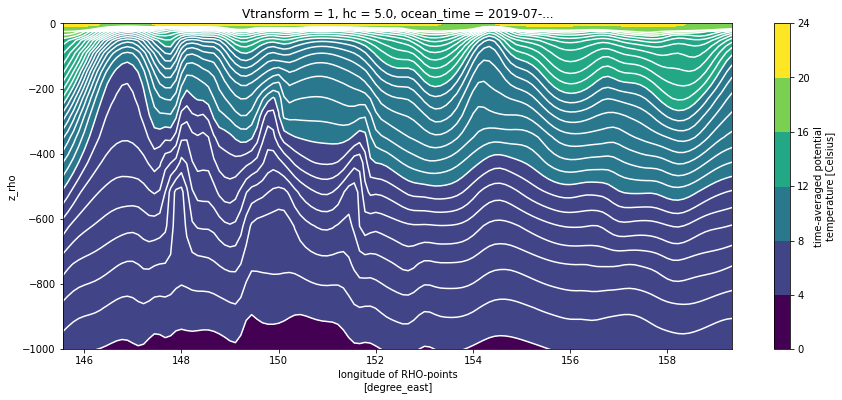

In [156]:
xi_rho=slice(275,400)
eta_rho=250
section.plot.contourf(x='lon_rho', y='z_rho', figsize=(15, 6), clim=(25, 35),linestyle='dashed')
plt.ylim([-1000, 1]);

section.plot.contour(x='lon_rho', y='z_rho', levels=np.arange(0,17.5, 0.5),colors='w')

#section[var].plot.contourf(levels=31, robust=True, cmap=cmap)

/home/gisuser/.conda/envs/ocean-deep/lib/python3.7/site-packages/xarray/plot/plot.py:943: UserWarning: The following kwargs were not used by contour: 'clim', 'linestyle'
  primitive = ax.contourf(x, y, z, **kwargs)


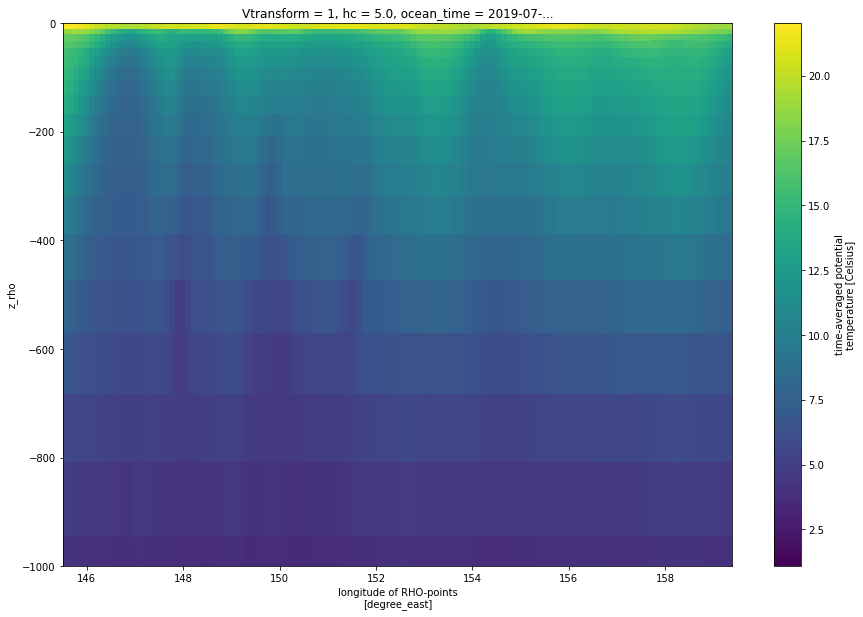

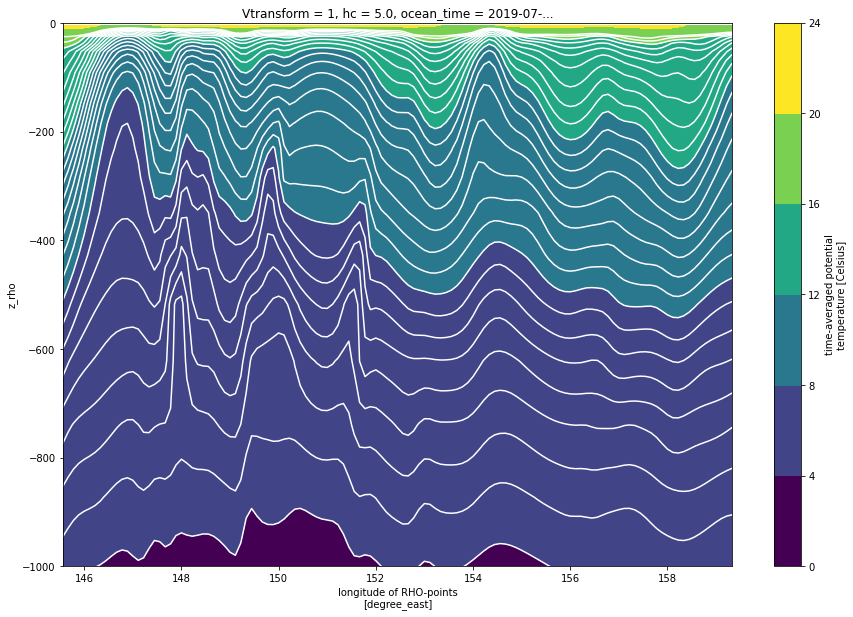

In [157]:
xi_rho=slice(275,400)
lat_rho=slice(200,300)
section.plot(x='lon_rho', y='z_rho',figsize=(15, 10))
plt.ylim([-1000, 1]);
section.plot.contourf(x='lon_rho', y='z_rho', figsize=(15, 10), clim=(25, 35),linestyle='dashed')
plt.ylim([-1000, 1]);

section.plot.contour(x='lon_rho', y='z_rho', levels=np.arange(0,17.5, 0.5),colors='w')

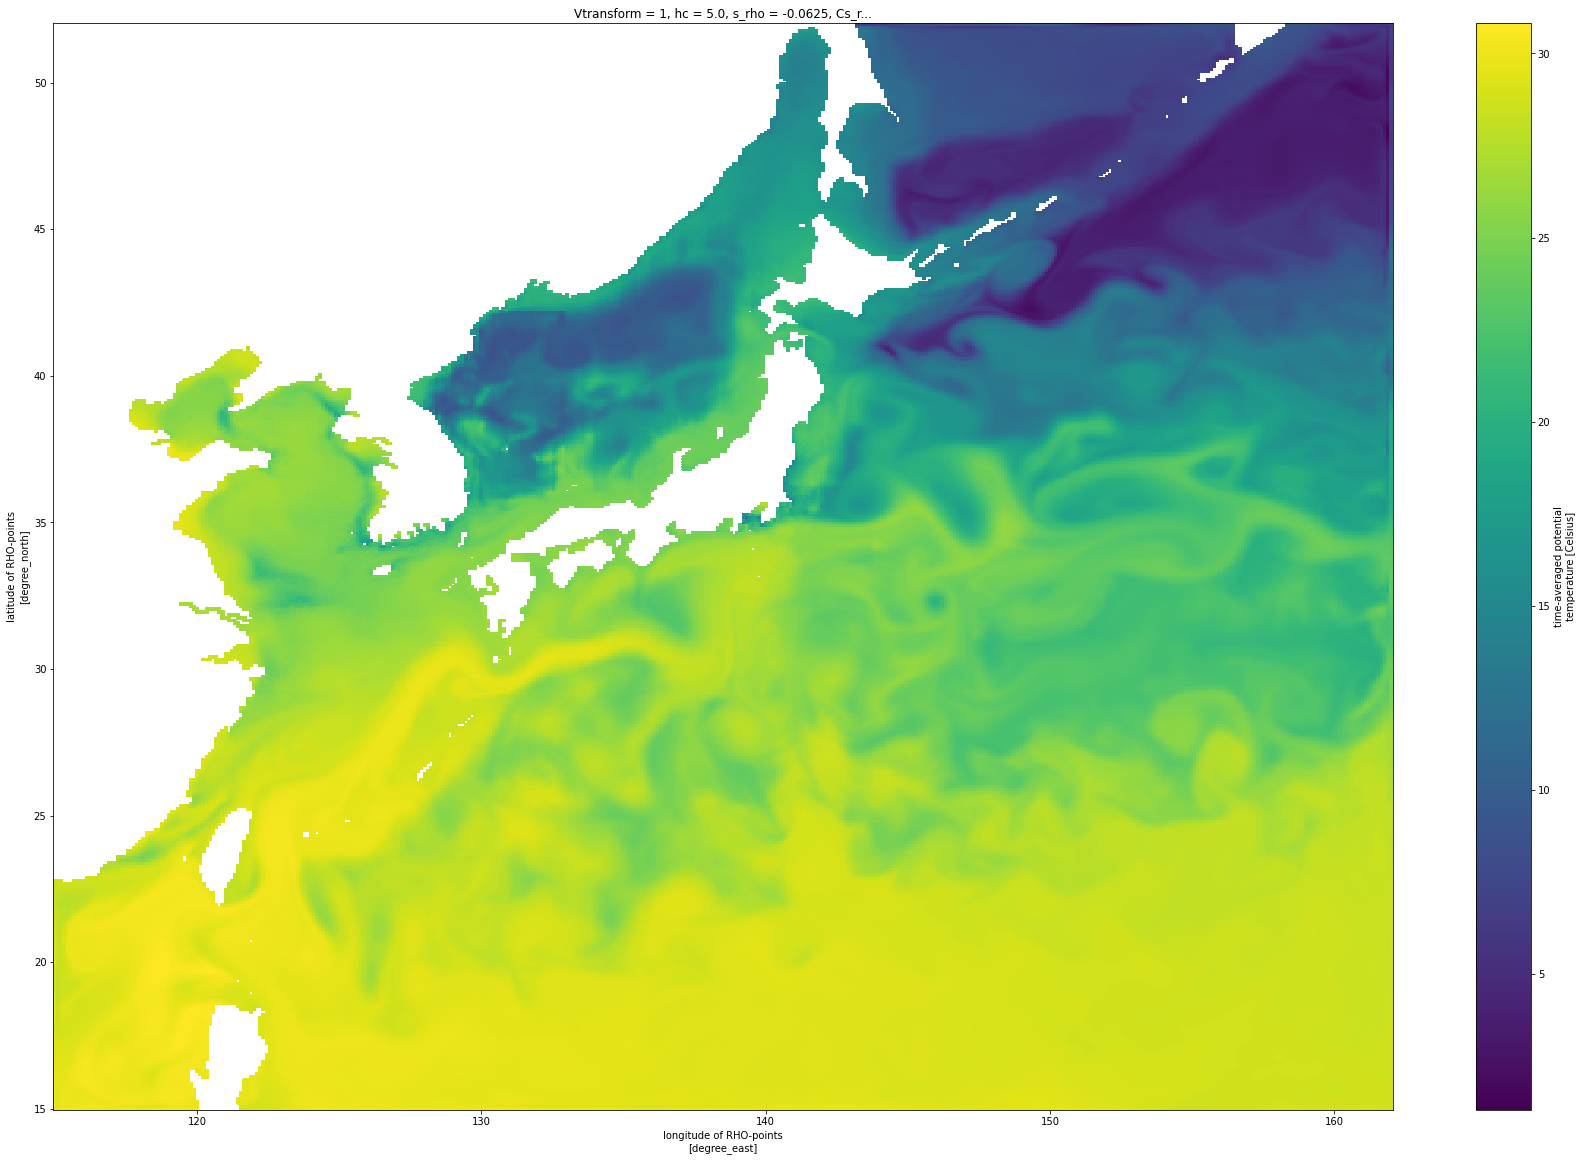

In [158]:
ds.temp.isel(s_rho=-3, ocean_time=0).plot(x='lon_rho', y='lat_rho',figsize=(30, 20))

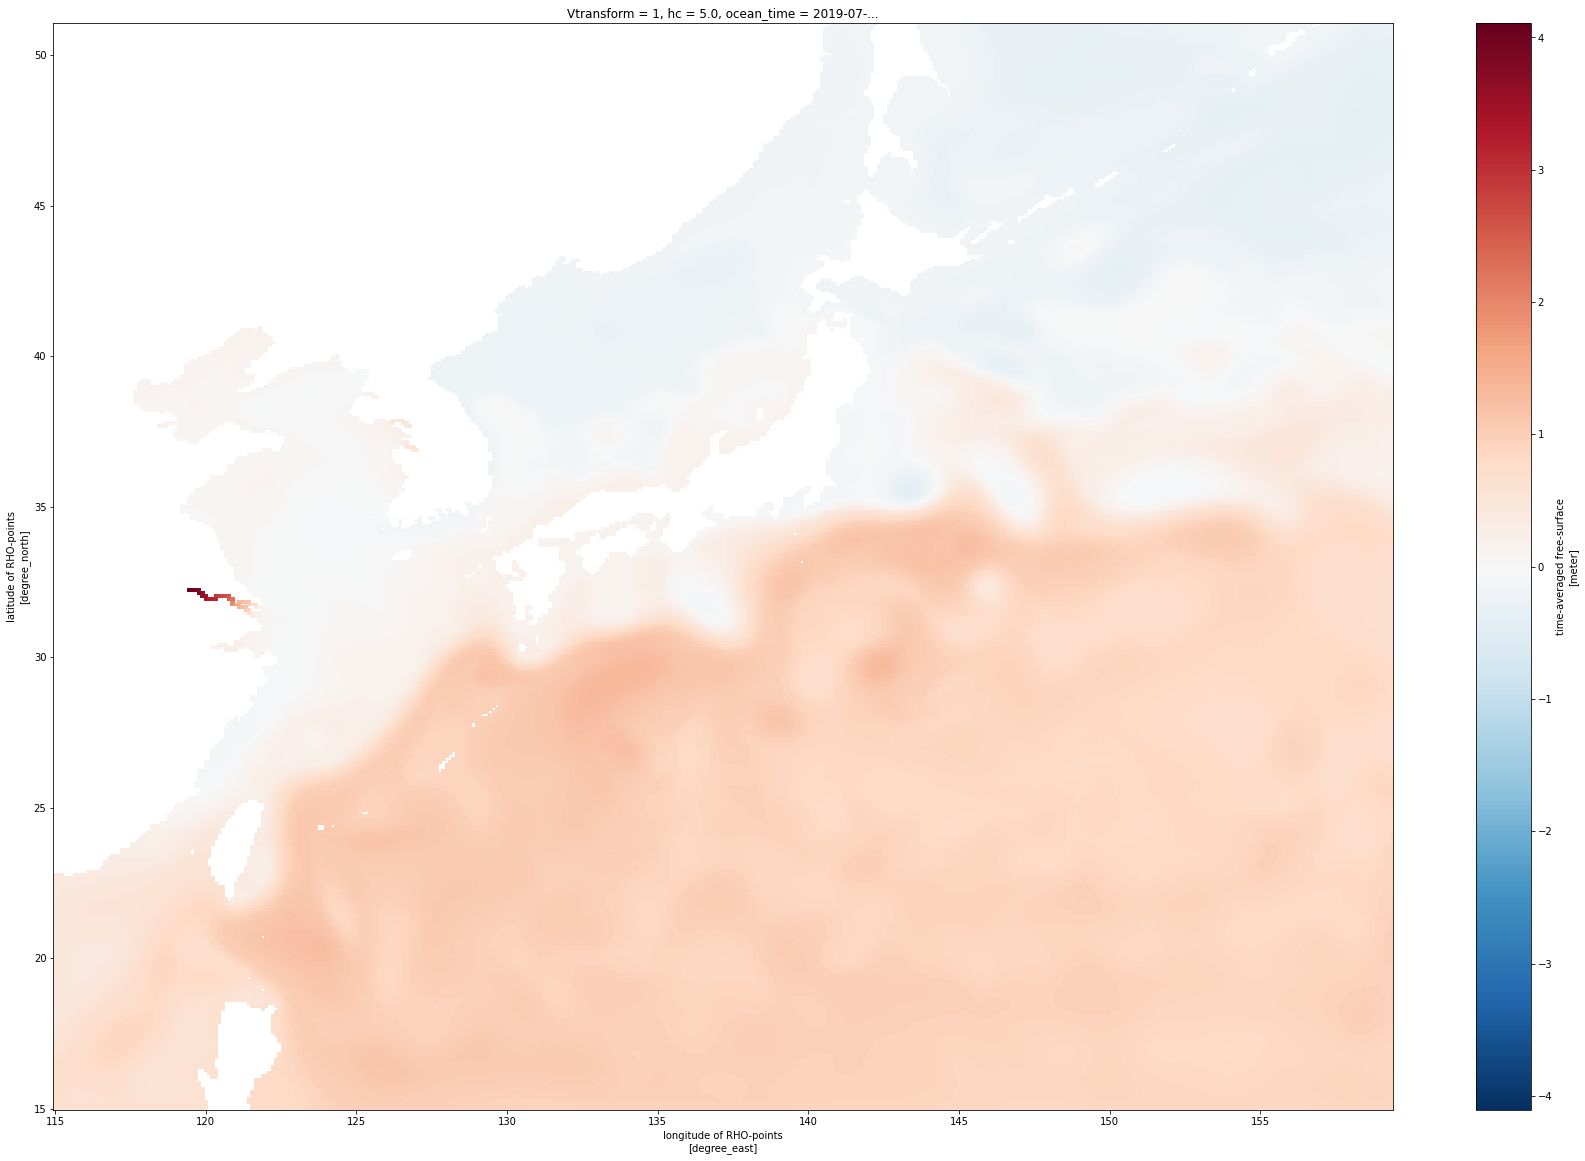

In [159]:
ds.zeta.isel(xi_rho=slice(0,400), eta_rho=slice(0,400), ocean_time=0).plot(x='lon_rho', y='lat_rho',figsize=(30, 20))

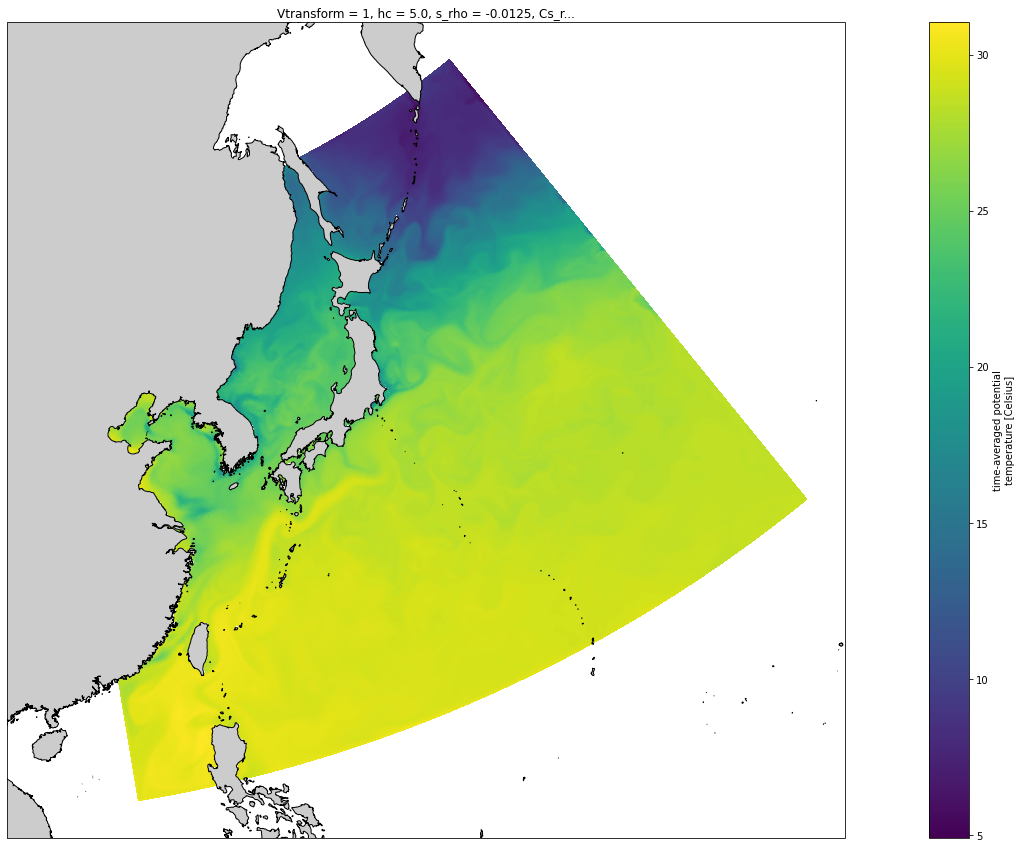

In [160]:
#proj = ccrs.LambertConformal(central_longitude=-92, central_latitude=29)
proj = ccrs.LambertConformal(central_longitude=100, central_latitude=29)
fig = plt.figure(figsize=(30, 15))
ax = plt.axes(projection=proj)
ds.temp.isel(s_rho=-1, ocean_time=0).plot(x='lon_rho', y='lat_rho',
                                          transform=ccrs.PlateCarree())

coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k', facecolor='0.8')
ax.add_feature(coast_10m)